In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ConstrEx(x):
    f1 = x[0]
    f2 = (1.0+x[1])/x[0]
    return np.array([f1,f2])

def constraints(x):
    c1 =  x[1] + 9.0*x[0]-6.0
    c2 = -x[1] + 9.0*x[0]-1.0
    return np.array([c1,c2])

In [3]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (0.1,1.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (0.0,5.0)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1,model_c2]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 33
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))
C_init = np.zeros((X_init.shape[0],2))

for i in range(num_init):
    Y_init[i,:] = ConstrEx(X_init[i,:])
    C_init[i,:] = constraints(X_init[i,:])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init,C_init)))

[[ 7.1364e-01  3.7879e-01  7.1364e-01  1.9321e+00  8.0152e-01  5.0439e+00]
 [ 8.2273e-01  2.0455e+00  8.2273e-01  3.7017e+00  3.4500e+00  4.3591e+00]
 [ 9.3182e-01  3.2576e+00  9.3182e-01  4.5691e+00  5.6439e+00  4.1288e+00]
 [ 6.3182e-01  8.3333e-01  6.3182e-01  2.9017e+00  5.1970e-01  3.8530e+00]
 [ 6.0455e-01  3.5606e+00  6.0455e-01  7.5439e+00  3.0015e+00  8.8030e-01]
 [ 2.7727e-01  9.8485e-01  2.7727e-01  7.1585e+00 -2.5197e+00  5.1061e-01]
 [ 3.8636e-01  4.4697e+00  3.8636e-01  1.4157e+01  1.9470e+00 -1.9924e+00]
 [ 8.5000e-01  2.1970e+00  8.5000e-01  3.7611e+00  3.8470e+00  4.4530e+00]
 [ 3.0455e-01  3.1061e+00  3.0455e-01  1.3483e+01 -1.5303e-01 -1.3652e+00]
 [ 1.4091e-01  4.1667e+00  1.4091e-01  3.6667e+01 -5.6515e-01 -3.8985e+00]
 [ 9.5909e-01  6.8182e-01  9.5909e-01  1.7536e+00  3.3136e+00  6.9500e+00]
 [ 4.9545e-01  1.2879e+00  4.9545e-01  4.6177e+00 -2.5303e-01  2.1712e+00]
 [ 9.8636e-01  4.9242e+00  9.8636e-01  6.0061e+00  7.8015e+00  2.9530e+00]
 [ 1.1364e-01  3.8636e+00

In [4]:
iter_count = 150-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    C_clip = np.copy(C_step)
    C_clip[C_clip > 0] = 0.0
    C_clip = np.sum(C_clip**2,axis=1)
    
    Pareto = ParetoFront(Y_step[C_clip==0.0,:])
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,jitter_c = np.array([0.0,0.0,0.0,0.0,0.0,0.0]),
                                  P=Pareto,r=np.array([2,10]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                                        model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = ConstrEx(x_next[0])
    c_next = constraints(x_next[0])
    print("Current iteration - ",current_iter," : ",np.hstack((x_next[0],y_next,c_next)))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

(6, 2)
Current iteration -  0  :  [0.4021 2.5522 0.4021 8.8331 0.1715 0.0671]
(7, 2)
Current iteration -  1  :  [0.9434 0.0358 0.9434 1.0979 2.5261 7.4546]
(7, 2)
Current iteration -  2  :  [0.936  3.9481 0.936  5.2863 6.3723 3.4761]
(7, 2)
Current iteration -  3  :  [0.9242 0.0254 0.9242 1.1095 2.343  7.2922]
(8, 2)
Current iteration -  4  :  [3.8963e-01 2.4986e+00 3.8963e-01 8.9793e+00 5.2535e-03 8.0473e-03]
(9, 2)
Current iteration -  5  :  [0.9338 1.1023 0.9338 2.2514 3.5062 6.3016]
(9, 2)
Current iteration -  6  :  [4.7832e-01 1.6952e+00 4.7832e-01 5.6348e+00 4.6249e-05 1.6096e+00]
(8, 2)
Current iteration -  7  :  [0.9407 0.3109 0.9407 1.3936 2.7772 7.1553]
(8, 2)
Current iteration -  8  :  [0.5447 1.1388 0.5447 3.9266 0.0411 2.7635]
(8, 2)
Current iteration -  9  :  [5.8717e-01 7.1554e-01 5.8717e-01 2.9217e+00 5.6741e-05 3.5690e+00]
(9, 2)
Current iteration -  10  :  [0.6482 0.3645 0.6482 2.1053 0.198  4.4689]
(10, 2)
Current iteration -  11  :  [0.4236 2.2073 0.4236 7.5713 0.01

KeyboardInterrupt: 

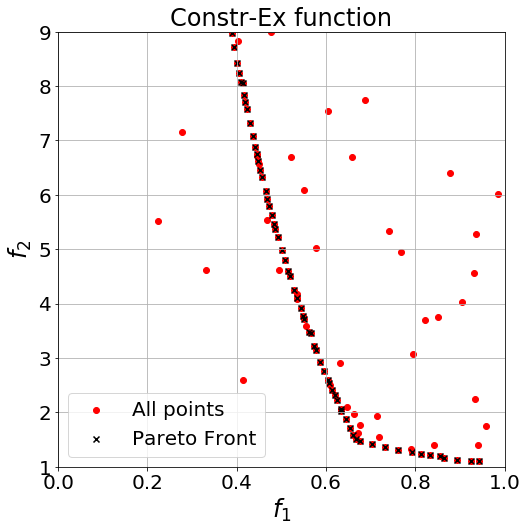

In [5]:
import matplotlib.pyplot as plt

C_clip = np.copy(C_step)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_step[C_clip==0.0,:])

fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='lower left',fontsize=20)
plt.xlim((0.0,1.0))
plt.ylim((1.0,9.0))

plt.grid()

plt.title("Constr-Ex function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Constr-Ex.png",bbox_inches='tight')
plt.show()

In [6]:
np.savez('Constr-Ex.npz',X_step=X_step,Y_step=Y_step,C_step=C_step)